<a href="https://colab.research.google.com/github/SnSabu/Machine-Learning-Projects/blob/main/Airline%20Passenger%20Satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Airline Passenger Satisfaction**


> *By* *Sneha* *Sabu*





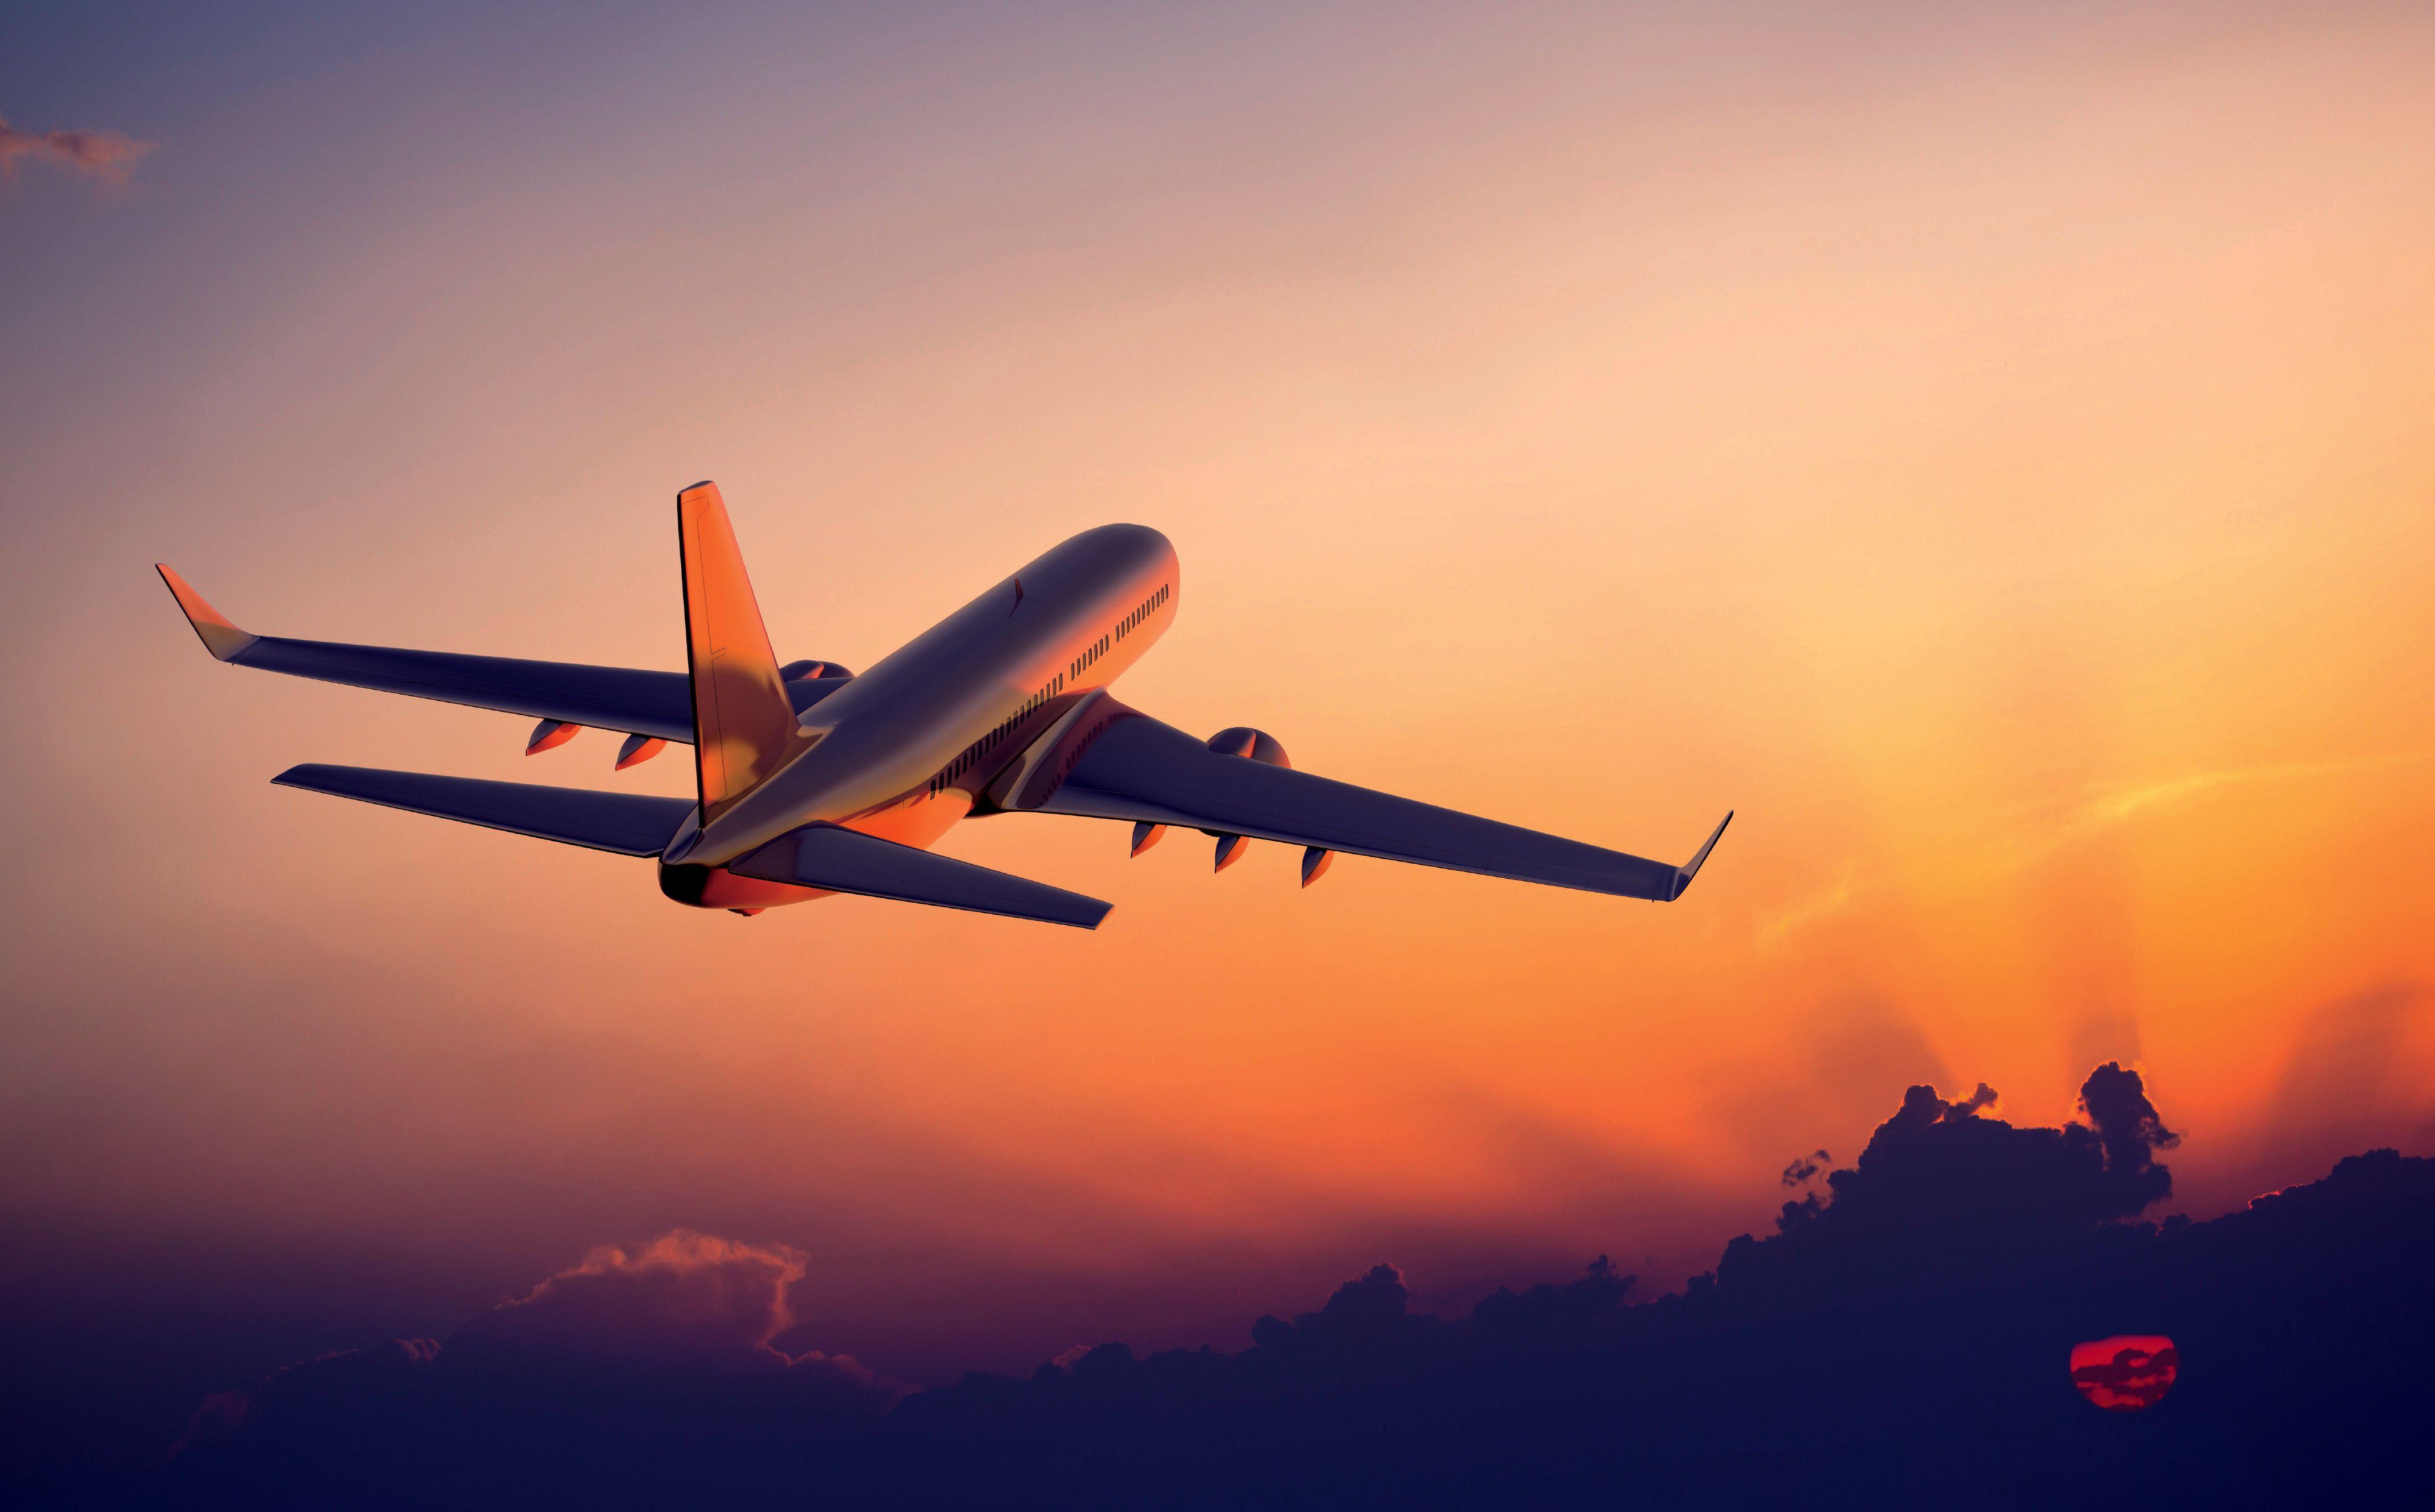

Air travel has become an essential part of modern life, and it is crucial for airlines to ensure customer satisfaction to retain their customers and remain competitive in the market. The dataset provided contains information about airline passenger satisfaction, which can be used to predict satisfaction and identify factors associated with customer satisfaction. The primary aim of this project is to build a model that predicts passenger satisfaction accurately and to determine which factors have the most significant impact on customer satisfaction. With this information, airlines can focus their efforts on improving areas that are critical to their customers and ultimately enhance the overall passenger experience.

# Data exploration and preparation

In this step, we will explore the dataset to understand the variables and their relationships. Missing values and outliers will be identified and handled appropriately. Data cleaning techniques such as normalization, standardization, and encoding categorical variables will be applied as needed.

In [29]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc


In [30]:
# Load the data
Data1 = pd.read_csv("/content/data1.csv")
Data2 = pd.read_csv("/content/data2.csv")
# Union the data
AirlineData = pd.concat([Data1, Data2], ignore_index= True)

In [31]:
#Drop the first column and id since it does not add value to analysis
AirlineData.drop(['Unnamed: 0','id'], axis=1, inplace=True)
# Check for NAs
AirlineData.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64

In [32]:
# Checking for data imbalance because it can affect the accuracy of the resulting models:
print(AirlineData['satisfaction'].value_counts()/ len(AirlineData) * 100)

neutral or dissatisfied    56.553742
satisfied                  43.446258
Name: satisfaction, dtype: float64


The data is fairly balanced with both classes contribuiting to approx 50% of the total




<ipython-input-57-b1141dc13729>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = AirlineData.corr()


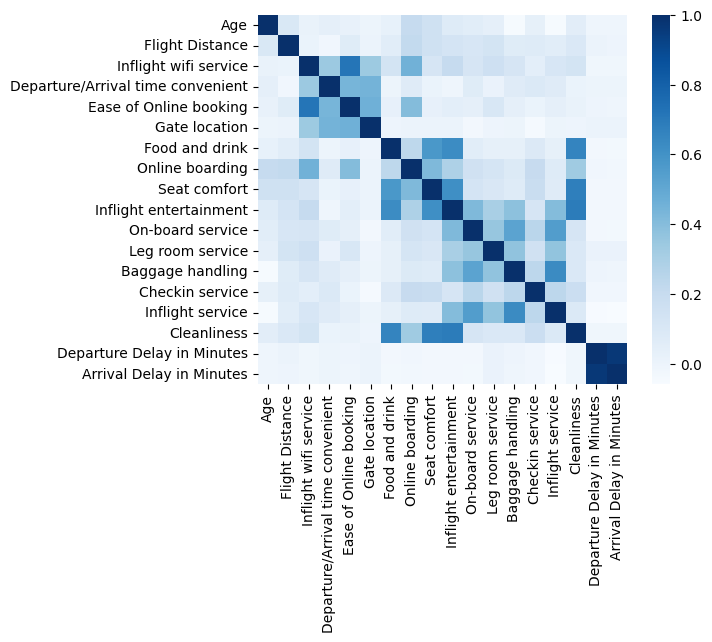

In [57]:
# Checking correlation of columns
corr_mat = AirlineData.corr()
sns.heatmap(corr_mat, square = True, cmap = 'Blues')
pass

There is a high correlation between "Departure Delay in Minutes" and "Arrival Delay in Minutes"

### Handling missing values
We see that there is a high correlation between "Departure Delay in Minutes" and "Arrival Delay in Minutes". When looking at the data, it can be noted that the delays for arival and departure are usually the same. Hence, we can treat the null values in "Arrival Delay in Minutes" by replacing it with values from "Departure Delay in Minutes"

In [33]:
AirlineData['Arrival Delay in Minutes'].fillna(AirlineData['Departure Delay in Minutes'], inplace=True)

In [34]:
AirlineData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Inflight wifi service              129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Ease of Online booking             129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Food and drink                     129880 non-null  int64  
 11  Online boarding                    1298

### Data Visualization

<ipython-input-117-c75a85e5bf6e>:3: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data=AirlineData, x='Age', hue = 'Type of Travel', bins=30, multiple = "stack", palette=sns.color_palette('pastel'))


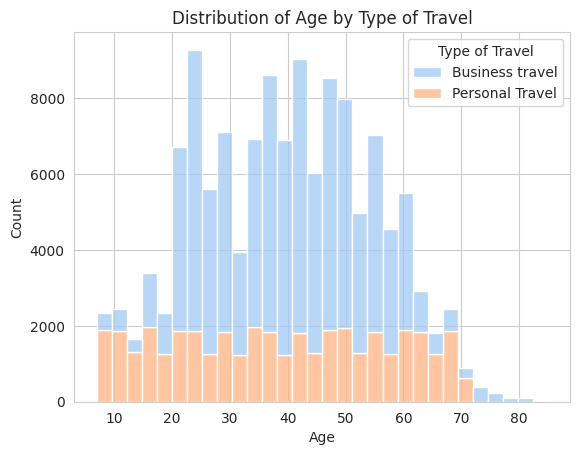

In [117]:
# Distribution of Age by Type of Travel
sns.set_style('whitegrid')
sns.histplot(data=AirlineData, x='Age', hue = 'Type of Travel', bins=30, multiple = "stack", palette=sns.color_palette('pastel'))
plt.title('Distribution of Age by Type of Travel')
plt.show()

We can conclude that most of the airline's passengers are middle aged and travel for business and the number of people who travel for personal reasons are uniformly distributed across different age groups.

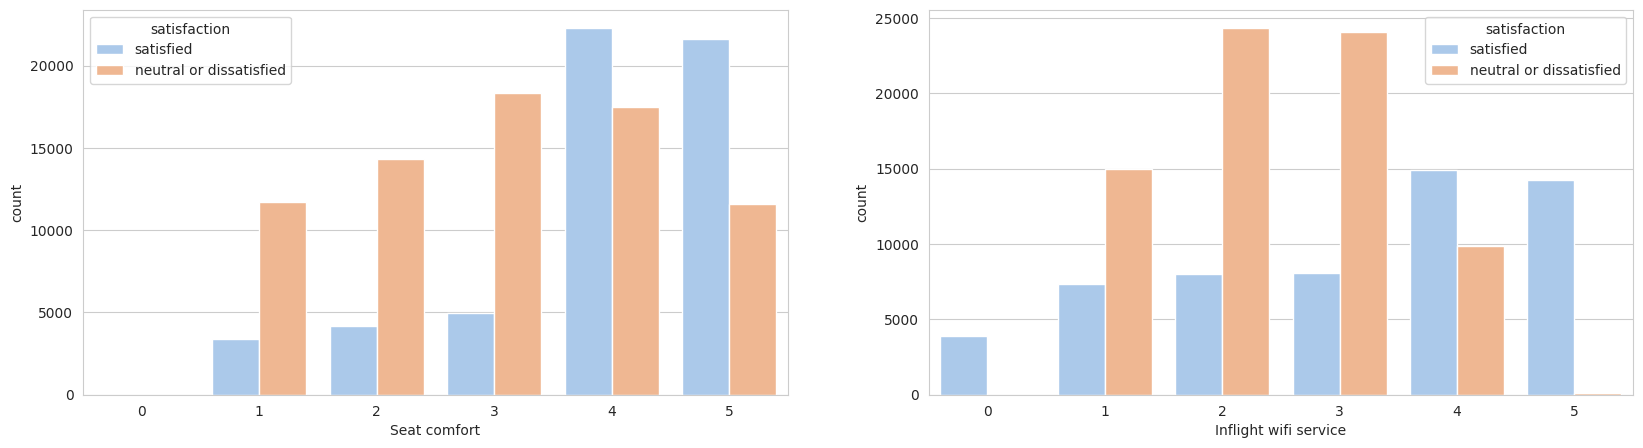

In [86]:
# Comparison of Seat Comfort and Inflight Wifi Service ratings with customer satisfaction levels
f, ax = plt.subplots(1, 2, figsize = (20,5))
sns.countplot(x = 'Seat comfort', hue = 'satisfaction', palette = "pastel", data = AirlineData,ax = ax[0])
sns.countplot(x = 'Inflight wifi service', hue = 'satisfaction', palette = "pastel", data = AirlineData, ax = ax[1])
plt.show()

From the graphs above, we can conclude the following: 

1. Most passengers who rated the comfort of the seats at 4 and 5 points out of 5 were satisfied with the flight.

2. Almost all passengers who rated the wifi service 5 out of 5 points were satisfied with the flight.

### Converting categorical variables to numerical 

The columns 'Gender', 'Customer Type', 'Type of Travel', and 'Class' columns are categorical variables, so they need to be converted to numerical values to be used in a classification algorithm. Here the one-hot encoding method is used for the same.

In [35]:
AirlineData = pd.get_dummies(AirlineData, columns=['Gender', 'Customer Type', 'Type of Travel', 'Class'])

### Normalizing numerical data 

The 'Age', 'Departure Delay in Minutes', and 'Arrival Delay in Minutes' columns are numerical data, and they are on different scales. Next, we will need to normalizing the data to ensure that the values are on a similar scale to avoid giving undue importance to a column with higher values.

In [36]:
scaler = MinMaxScaler()
AirlineData[['Age', 'Flight Distance','Departure Delay in Minutes', 'Arrival Delay in Minutes']] = scaler.fit_transform(AirlineData[['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']])


The possible sources of this Airline survey data could be customer feedback forms, online reviews, or questionnaires. 

Some of the issues that should be considered when working with this data include the representativeness of the sample, the accuracy of the responses, the wording and design of the survey questions, and the potential for response bias. In addition, missing data and outliers may also pose challenges when working with survey data.

Although the dataset contains a large number of variables related to the customer experience, some key variables, such as the reasons behind customer satisfaction or dissatisfaction, are not included. In addition, there are missing values in the "Arrival Delay in Minutes" variable, which may affect the accuracy of the results.  

Future surveys could be improved by including more detailed questions about the customers' experiences, and by ensuring that the data is complete and accurate. Additionally, efforts can be made to reduce response bias and other potential sources of error.


The results of the analysis can be helpful to the airline by identifying the key factors that affect customer satisfaction. The airline can use this information to improve the quality of its services and customer experience, potentially leading to increased customer loyalty and business success.

# Modelling

Data preparation before modelling - Before training the machine learning model, the target variable needs to be converted to the expected class - 0 and 1 instead of neutral or dissatisfied and satisfied. Then the data is split into target (y) variable and predictor (x) variables.



In [37]:
AirlineData['satisfaction'] = AirlineData['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})

In [56]:
y = AirlineData['satisfaction']
X = AirlineData.drop(columns=['satisfaction'])

### XGBoost Model

In [57]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define the model
xgboost = XGBClassifier(n_estimators = 1000, max_depth = 5, learning_rate = 0.05).fit(X_train, y_train, early_stopping_rounds = 5, eval_set = [(X_test, y_test)],verbose = False)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


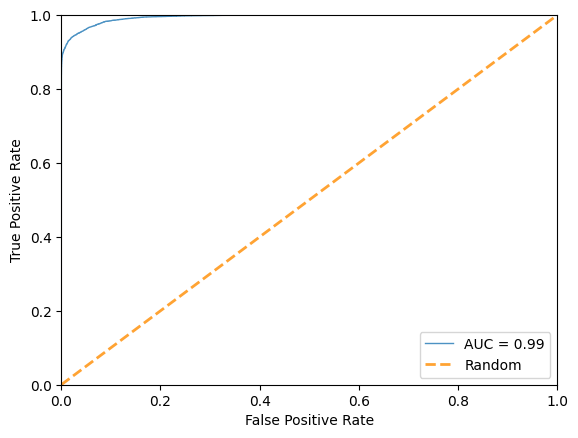

Accuracy: 0.96
Precision: 0.97
Recall: 0.94
F1-score: 0.96
Confusion matrix:
 [[14424   310]
 [  680 10562]]


In [55]:
# calculate predictions
y_pred = xgboost.predict(X_test)

# calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

# calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, xgboost.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='AUC = %0.2f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='darkorange', label='Random', alpha=.8)
plt.legend(loc="lower right")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# print evaluation metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))
print("Confusion matrix:\n", confusion)

The accuracy of 0.96 means that the model has correctly predicted 96% of the observations in the test set. The precision of 0.97 means that of all the positive predictions made by the model, 97% were correct. The recall of 0.94 means that of all the true positive observations in the test set, the model correctly identified 94%. The F1-score of 0.96 is a weighted average of precision and recall, which gives a balance between the two measures. Finally, the AUC score of 0.99 suggests that the model has very good discriminatory power and can effectively distinguish between positive and negative samples.

Overall, the output suggests that the XGBoost model performed very well in classifying the test data.






### Random Forest

In [ ]:
# Define the model
RandomForestModel = RandomForestClassifier(max_depth=2, random_state=0)

# Train the model on the training data
RandomForestModel.fit(X_train, y_train)

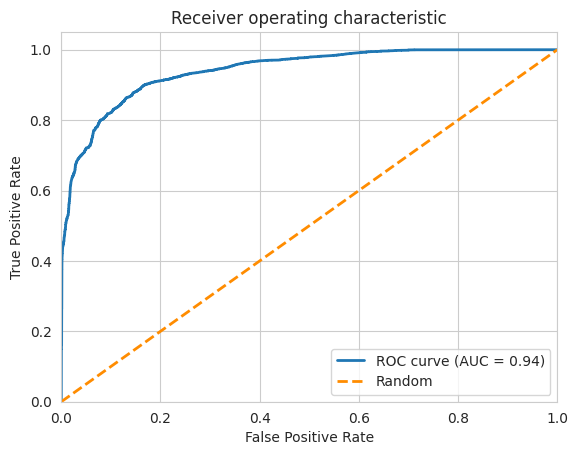

Accuracy: 0.87
Precision: 0.87
Recall: 0.81
F1 Score: 0.84
Confusion Matrix:
 [[13371  1363]
 [ 2081  9161]]
AUC: 0.94


In [175]:
# Calculate predictions
y_pred = RandomForestModel.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Calculate ROC curve and AUC
y_score = RandomForestModel.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkorange', label='Random', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Print evaluation metrics
print('Accuracy: %.2f' % accuracy)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)
print('F1 Score: %.2f' % f1)
print('Confusion Matrix:\n', cm)
print('AUC: %.2f' % roc_auc)


The Random Forest model has an accuracy and precision of 0.87 and a recall of 0.81. This means that the model has correctly predicted 87% of the observations in the test set and 87% of all the positive predictions made by the model were correct. The model also correctly identified 81% of all positive observations. Finally, the AUC score of 0.94 suggests that the model has very good discriminatory power and can effectively distinguish between positive and negative samples.

Overall, the output suggests that the Random Forest model performed very well in classifying the test data.

### Naive Bayes

In [20]:
# Training the Naive Bayes model on the Training set
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)


In [26]:
# Computing evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Printing the evaluation metrics
print("Accuracy: %.2f" % accuracy)
print("Precision: %.2f" % precision)
print("Recall: %.2f" % recall)
print("F1 Score: %.2f" % f1)
print("Confusion Matrix: \n", conf_matrix)


Accuracy: 0.85
Precision: 0.83
Recall: 0.82
F1 Score: 0.83
Confusion Matrix: 
 [[10466  1570]
 [ 1642  7611]]


The accuracy of 0.85 means that the model has correctly predicted 85% of the observations in the test set. The precision of 0.83 means that of all the positive predictions made by the model, 83% were correct. The recall of 0.82 means that of all the true positive observations in the test set, the model correctly identified 82%. 

Overall, the output suggests that the Naive Bayes model performed well in classifying the test data.

# Model Comparison

The XGBoost has the highest accuracy, precision, recall, and F1-score, indicating a better overall performance compared to the other two models. The XGBoost model also has a high AUC score of 0.99 which shows that it does exceptionally well in distinguishing between the two classes.


Based on the performance metrics, the Naive Bayes model appears to be slightly better than the Random Forest. The Naive Bayes model has a higher accuracy, a similar precision, and a slightly higher recall and F1-score.

# Feature Importance

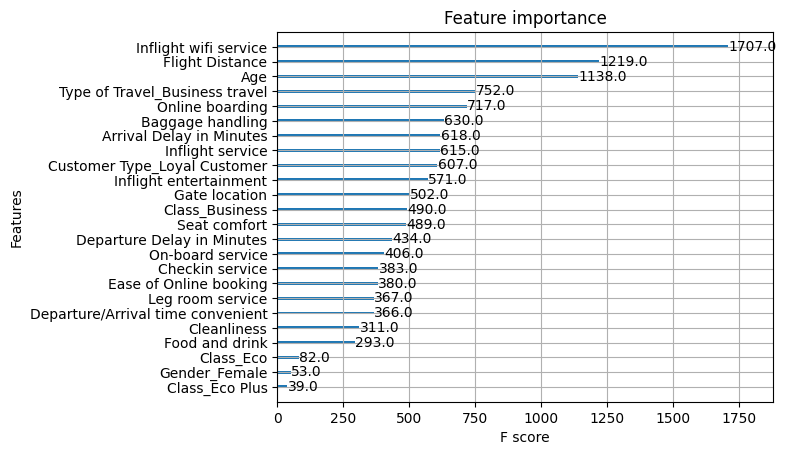

In [58]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance
plot_importance(xgboost)
plt.show()


When looking at the importance of features used in XGBoost, it can be seen that Inflight Wifi Service, Flight Distance, Age, Type of Travel and Online Boarding are variables that have a significant effect on overall customer satisfaction. Inflight Wifi Service, Flight Distance, Type of Travel and Online Boarding are factors that can directly impact a customer's experience during their flight, and ultimately influence their satisfaction. Age may also play a role in this, as older passengers may have different preferences and expectations compared to younger passengers. 